The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-tvm
!pip install https://tvm-repo.s3-us-west-2.amazonaws.com/cuda10.0-llvm6.0/tvm-0.6.dev0-cp36-cp36m-linux_x86_64.whl https://tvm-repo.s3-us-west-2.amazonaws.com/cuda10.0-llvm6.0/topi-0.6.dev0-py3-none-any.whl


# Depthwise Convolution

:label:`ch_depthwise_conv_gpu`


In this section, we will talk about how to optimize depthwise convolution on GPUs.

In [1]:
import d2ltvm
import numpy as np
import timeit
import tvm

target = 'cuda'

## Setup

The baseline of depthwise convolution on GPUs is given by MXNet, which relies on cuDNN for high performance. Again, we benchmark the performance with various numbers of channels, when the input and kernel width/height are fixed to be 64 and 3, respectively. 
The benchmark method `depthwise_conv_timer_mxnet` has already been defined in :numref:`ch_depthwise_conv_cpu`. 
The only change that we need to make is to specify to the method that the target device is `GPU`.

[10.267500395828796,
 20.333264675099674,
 39.395680100765226,
 79.45591945461335,
 116.73523949703082]

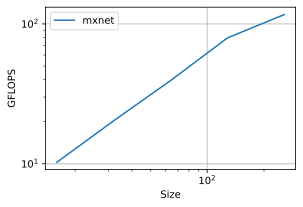

In [2]:
channels = 2**np.arange(4, 9)
# a list of (c, n, k)
sizes = [(int(c), 64, 3) for c in channels]
mx_gflops = d2ltvm.bench_depthwise_conv_mxnet(sizes, 'gpu')
d2ltvm.plot_gflops(channels, [mx_gflops], ['mxnet'])
mx_gflops

It is expected to see that the performance of depthwise convoluyion on GPUs increases while the number of channels increases.

## Default schedule of Depthwise Convolution

In order to show the effectiveness of scheduling, we first apply a default schedule, which does nothing but only binds the axes to GPU thread and block.

array([24.94006518, 24.81788457, 24.84385363, 24.95000301, 24.94957967])

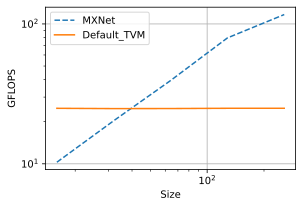

In [3]:
def default_sch(ic, n, k, p, s):
    X, K, Y, PaddedX = d2ltvm.depthwise_conv(ic, n, n, k, k, p, p, s, s)
    sch = tvm.create_schedule(Y.op)
    sch[PaddedX].compute_inline()
    _, y, x = sch[Y].op.axis
    sch[Y].bind(y, tvm.thread_axis("blockIdx.x"))
    sch[Y].bind(x, tvm.thread_axis("threadIdx.x"))
    return sch, (X, K, Y)

default_tvm_gflops = d2ltvm.bench_depthwise_conv_tvm(default_sch, sizes, target)
d2ltvm.plot_gflops(channels, [mx_gflops, default_tvm_gflops], legend=['MXNet', 'Default_TVM'])
default_tvm_gflops

The default scheduling gives us the performance around 25 GFLOPS for every data shape we investigate, indicating that the compute power is not actually used.

## Scheduling of Depthwise Convolution

We work on the scheduling of depthwise convolution from the following aspects. Note that none of them is new, all covered in the previous sections.

Remember that the depthwise convolution convolves each input channel with a dedicated kernel, we can simply assign each channel to a different CUDA block. By doing this, we make different SMs work on different portions of the data, avoiding data contention across channels.

In terms of tiling, we followed the same trick done in :numref:`ch_conv_gpu` to bring some data to the shared and local memory of the GPU. You can follow the analytics approach described in :numref:`ch_conv_gpu` to calculate the cached data size and make sure the data fits in the cache. And we continue doing the cooperative fetching as before.

There is another key point for getting the good performance out of a GPU, which is mitigating the bank conflict described in :numref:`ch_conv_gpu`. Unlike using the virtual thread in :numref:`ch_conv_gpu`, this time we manipulate the data access pattern as illustrated in :numref:`fig_conv_row_column`. That is, we read the data in columns to bring them into the local memory.

array([300.73618251, 491.75793274, 530.13742883, 460.45125096,
       305.35322722])

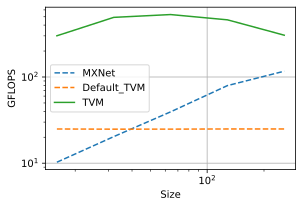

In [4]:
tile_c = [1, 1]  # making each block take 1 channel
tile_h = [2, 8]  # making each thread take 8 rows
tile_w = [64, 1] # making each thread take 1 column

def schedule(ic, n, k, p, s):
    X, K, Y, PaddedX = d2ltvm.depthwise_conv(ic, n, n, k, k, p, p, s, s)
    sch = tvm.create_schedule(Y.op)
    sch[PaddedX].compute_inline()

    YL = sch.cache_write(Y, 'local')
    # create cache stage
    XX = sch.cache_read(PaddedX, 'shared', [YL])
    KK = sch.cache_read(K, 'shared', [YL])
    XL = sch.cache_read(XX, 'local', [YL])
    KL = sch.cache_read(KK, 'local', [YL])

    # tile and bind spatial axes
    c, h, w = sch[Y].op.axis
    bc, tc, ic = d2ltvm.split_axis(tile_c, sch, Y, c)
    bh, th, ih = d2ltvm.split_axis(tile_h, sch, Y, h)
    bw, tw, iw = d2ltvm.split_axis(tile_w, sch, Y, w)
    
    sch[Y].bind(bc, tvm.thread_axis("blockIdx.z"))
    sch[Y].bind(bh, tvm.thread_axis("blockIdx.y"))
    sch[Y].bind(bw, tvm.thread_axis("blockIdx.x"))
    sch[Y].bind(tc, tvm.thread_axis("threadIdx.z"))
    sch[Y].bind(th, tvm.thread_axis("threadIdx.y"))
    sch[Y].bind(tw, tvm.thread_axis("threadIdx.x"))
    sch[Y].reorder(bc, bh, bw, tc, th, tw, ic, ih, iw)

    sch[YL].compute_at(sch[Y], tw)
    
    sch[XX].compute_at(sch[Y], bw)
    sch[KK].compute_at(sch[Y], bw)
    sch[XL].compute_at(sch[Y], tw)
    sch[KL].compute_at(sch[Y], tw)
    
    # cooperative fetching
    for load in [XX, KK]:
        args = sch[load].op.axis
        fused = sch[load].fuse(*args)
        # align thread layout
        tz, fused = sch[load].split(fused, nparts=tile_c[0])
        ty, fused = sch[load].split(fused, nparts=tile_h[0])
        tx, _ = sch[load].split(fused, nparts=tile_w[0])
        sch[load].bind(tz, tvm.thread_axis("threadIdx.z"))
        sch[load].bind(ty, tvm.thread_axis("threadIdx.y"))
        sch[load].bind(tx, tvm.thread_axis("threadIdx.x"))
    return sch, (X, K, Y)

tvm_gflops = d2ltvm.bench_depthwise_conv_tvm(schedule, sizes, target)
d2ltvm.plot_gflops(channels, [mx_gflops, default_tvm_gflops, tvm_gflops], legend=['MXNet', 'Default_TVM', 'TVM'])
tvm_gflops

We can see that after properly scheduling the computation, TVM can boost the performance of depthwise convolution by over one order of magnitude, which is also much better that the MXNet baseline.

It is worthwhile noting that, in the real workloads, depthwise convolution consumes only a little computation, which can be finished in microseconds. Therefore, although TVM outperforms MXNet for quite a lot, the real executing time difference is marginal. This somewhat reflects the famous [Amdahl's law](https://en.wikipedia.org/wiki/Amdahl%27s_law), i.e. in the real use case, we should first focus on optimizing the hot spots which takes the majority of executing time.

## Summary
- Optimizing the depthwise convolution on GPUs has no major difference from optimizing other operators. The same techniques, e.g. parallelization, tiling, apply.

## Exercise
- Try to use virtual thread to mitigate the bank conflict in depthwise convolution.
- Vary the size of input data and observe the performance difference.